Script for evaluating a single slide. 

Instructions:
    - Define the path for the slide .tif file to be evaluated
    - Define the path for the mask .tif file to be evaluated
    - Define the path for the model folder 
    - Run all cells

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import progressbar
import sys
import datetime
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn
from sklearn.metrics import roc_auc_score
from scipy.ndimage import measurements, binary_dilation
from tensorflow.keras.utils import plot_model

In [25]:
model_path = "./mobilnetv2_3_fine_tuned"
slide_path = "tumor_110.tif"
mask_path = "tumor_110_mask.tif"

In [26]:
model = tf.keras.models.load_model(model_path)
highest_zoom = 1
stride = 128
offset = 2
BATCH_SIZE = 512
threshold = .6

"""
Reads a given slide and either saves it to a given filepath or returns it as a numpy array

Parameters:
    slide [slide]: slide object returned from open_slide()
    x [int]: top-left x coordinate to start reading slide from
    y [int]: top-left y coordinate to start reading slide from
    level [int]: zoom level to read slide from
    width [int]: width of output slide
    height [int]: height of output slide 
    file_path [string]: (optional) if provided, function will save the patch to the given file location
Returns:
    Slide patch as a numpy array if no file_path given, otherwise, nothing
"""
def read_slide(slide, x, y, level, width, height, file_path=None):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB')
    if file_path:
        im.save(file_path)
    else:
        im = np.asarray(im)
        return im

"""
Determines if image is sufficiently grey

Parameter:
    image [np.array([float])]: image to analyze
    threshold [float]: fraction of pixels which must be grey in order to return true
    intensity [float]: grayscale threshold to be considered a grey pixel
Return:
    boolean: true if image is grey, false otherwise
"""
def Is_Grey(image, threshold=.8, intensity=0.8):
    num_pixels = image.shape[0]*image.shape[1]
    im_gray = rgb2gray(image)
    num_grey_pixels = np.count_nonzero(im_gray >= intensity)
    return True if ((num_grey_pixels/num_pixels) > threshold) else False

"""
Determines the number of cancerous regions in a slide and plots them along with the regions the model did not detect.

Parameters:
    mask_image [numpy.array([int])]: true value slide mask
    predicted_mask [numpy.array(int)]: predicted slide mask
    file_path [string]: file path to story saved masks
Returns:
    None
"""
def Compute_And_Plot_Custom_Metric(mask_image,predicted_mask):
    structure = np.ones((3,3))
    new_mask_image = binary_dilation(mask_image,structure)
    structure = np.ones((3,3))
    lw, num = measurements.label(new_mask_image,structure)

    area = measurements.sum(new_mask_image, lw, index=np.arange(lw.max() + 1))
    index_count = list(zip(area,range(len(area))))

    remove = []
    for i,j in index_count:
        if i < 2:
            remove.append(j)
    reduced_array = np.where(np.isin(lw,np.array(remove)), 0.0, lw)
    categories = np.unique(reduced_array)

    undetected_cat = []
    overlap = 0
    for cat in categories:
        cnt = np.sum((np.where(predicted_mask==0,-1,predicted_mask)*cat)==reduced_array)
        if cnt > 0:
            overlap += 1
        else:
            undetected_cat.append(cat)

    metric = (overlap-1)/(categories.shape[0]-1)
    print("Percentage of Cancerous Regions Identified:",metric*100,"%")

    fig, ax = plt.subplots(1,2,figsize=(20,20))

    _=ax[0].imshow(slide_image)
    _=ax[0].imshow(lw,alpha=.8)
    _=ax[0].set_title(str(categories.shape[0]-1) +" Cancerous Regions")
     
    non_detected_cancerous_array = np.where(np.isin(reduced_array,undetected_cat),categories.shape[0]**2,0)

    _=ax[1].imshow(slide_image)
    _=ax[1].imshow(non_detected_cancerous_array,alpha=.8)
    _=ax[1].set_title(str(categories.shape[0]-overlap) +" Non-Detected Cancerous Region(s)")

'\nReads a given slide and either saves it to a given filepath or returns it as a numpy array\n\nParameters:\n    slide [slide]: slide object returned from open_slide()\n    x [int]: top-left x coordinate to start reading slide from\n    y [int]: top-left y coordinate to start reading slide from\n    level [int]: zoom level to read slide from\n    width [int]: width of output slide\n    height [int]: height of output slide \n    file_path [string]: (optional) if provided, function will save the patch to the given file location\nReturns:\n    Slide patch as a numpy array if no file_path given, otherwise, nothing\n'

'\nDetermines if image is sufficiently grey\n\nParameter:\n    image [np.array([float])]: image to analyze\n    threshold [float]: fraction of pixels which must be grey in order to return true\n    intensity [float]: grayscale threshold to be considered a grey pixel\nReturn:\n    boolean: true if image is grey, false otherwise\n'

'\nDetermines the number of cancerous regions in a slide and plots them along with the regions the model did not detect.\n\nParameters:\n    mask_image [numpy.array([int])]: true value slide mask\n    predicted_mask [numpy.array(int)]: predicted slide mask\n    file_path [string]: file path to story saved masks\nReturns:\n    None\n'

100% (280 of 280) |######################| Elapsed Time: 0:21:51 Time:  0:21:51


Slide Number: 064 AUC_ROC: 0.9741138948093055 TP: 15415 FP: 937 TN: 86029 FN: 659
Percentage of Cancerous Regions Identified: 100.0 %


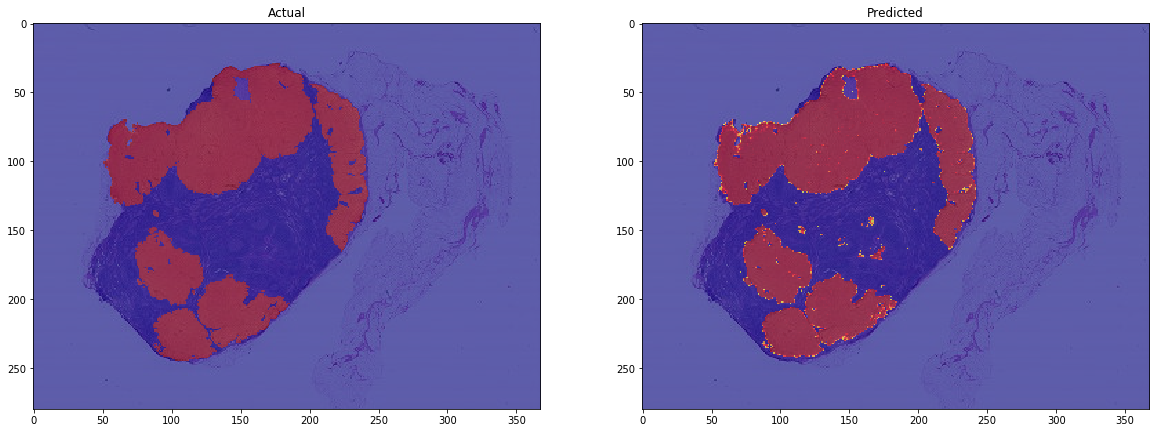

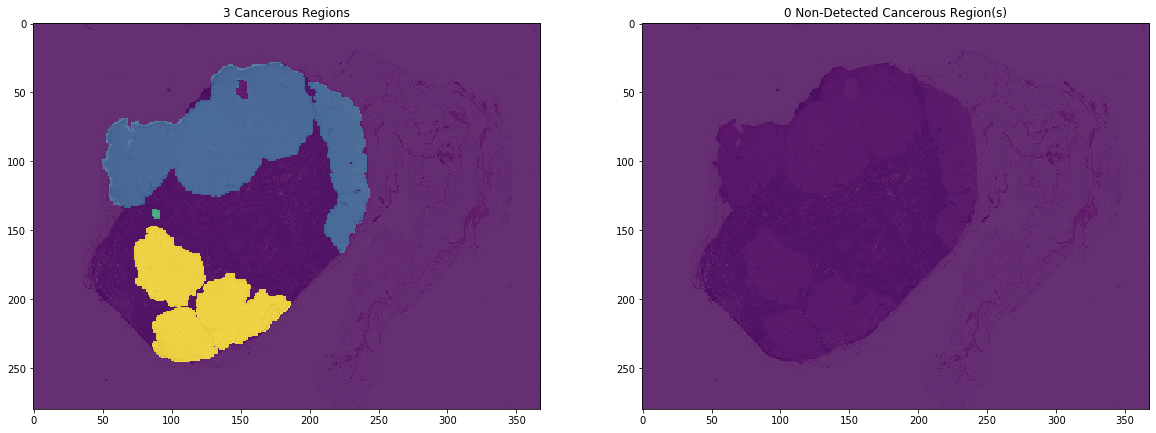

In [27]:
# script for evaluating a full slide
# iterates through all the 299X299 patches of a slide and stores the prediction in an array which becomes the heatmap

slide = open_slide(slide_path)

dimensions = slide.level_dimensions
downsamples = slide.level_downsamples
highest_dimensions = dimensions[highest_zoom]
highest_downsample = int(downsamples[highest_zoom])

x,y = highest_dimensions
x_range = int(x/128)
y_range = int(y/128)

def Get_Test_Data(coordinates):
    images_batch = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coordinates_batch = tf.TensorArray(tf.int32, size=0, dynamic_size=True) 
    for coordinate in coordinates:
        img = read_slide(slide, 
                x=int(128*coordinate[0]*highest_downsample)-85,
                y=int(128*coordinate[1]*highest_downsample)-85,
                level=highest_zoom, width=299, height=299)
        if Is_Grey(img):
            continue
        standard_img = img/255.0
        images_batch = images_batch.write(images_batch.size(),standard_img)
        coordinates_batch = coordinates_batch.write(coordinates_batch.size(),coordinate)
    return images_batch.stack(), coordinates_batch.stack()

indexes = []
y=-stride+(offset)*stride
for j in range(offset,y_range-offset):
    y += stride 
    x = -stride+(offset)*stride
    for i in range(offset,x_range-offset):
        indexes.append([i,j]) # x,y

dataset = tf.data.Dataset.from_tensor_slices(indexes).batch(BATCH_SIZE).map(lambda x: tf.py_function(func=Get_Test_Data,inp=[x],Tout=[tf.float32,tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE).filter(lambda a,b: tf.not_equal(tf.size(b), 0)).prefetch(tf.data.experimental.AUTOTUNE)

predicted_mask = np.zeros((y_range,x_range))
heatmap_mask = np.zeros((y_range,x_range))
with progressbar.ProgressBar(max_value=y_range) as bar:  
    for i,j in dataset:
        predictions = model.predict(i)
        for count, prediction in enumerate(predictions):
            if prediction[0] >= threshold:
                predicted_mask[j[count][1],j[count][0]] = 1 
                heatmap_mask[j[count][1],j[count][0]] = prediction[0]
            bar.update(j[count][1].numpy())

slide = open_slide(slide_path)
slide_image = read_slide(slide,x=0,y=0,level=8, 
                            width=slide.level_dimensions[8][0], 
                            height=slide.level_dimensions[8][1])

mask = open_slide(mask_path)
mask_image = read_slide(mask,x=0,y=0,level=8, 
                        width=mask.level_dimensions[8][0], 
                        height=mask.level_dimensions[8][1])[:,:,0]
    
tn, fp, fn, tp = confusion_matrix(mask_image.reshape(1,-1)[0], (predicted_mask).reshape(1,-1)[0]).ravel()
auc_roc = roc_auc_score(mask_image.reshape(1,-1)[0], (predicted_mask).reshape(1,-1)[0])
print("Slide Number:",slide_number, "AUC_ROC:",auc_roc,"TP:",tp,"FP:",fp,"TN:",tn,"FN:",fn)

fig, ax = plt.subplots(1,2,figsize=(20,20))
_=ax[0].set_title("Actual")
_=ax[0].imshow(slide_image)
_=ax[0].imshow(mask_image, cmap='jet', alpha=.6)
_=ax[1].set_title("Predicted")
_=ax[1].imshow(slide_image)
_=ax[1].imshow(heatmap_mask, cmap='jet', alpha=.6)

Compute_And_Plot_Custom_Metric(mask_image,predicted_mask)